In [1]:
pip install scikit-learn pandas numpy mlxtend matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


--- Step 1: Synthetic Patient Data Generated ---
   Heart_Rate  Blood_Pressure                          Treatments
0   82.483571      159.308678  [Aspirin, Beta_Blocker, Diet_Plan]
1   83.238443      167.615149     [Aspirin, Beta_Blocker, Statin]
2   78.829233      158.829315  [Aspirin, Beta_Blocker, Diet_Plan]
3   87.896064      163.837174     [Aspirin, Beta_Blocker, Statin]
4   77.652628      162.712800     [Aspirin, Beta_Blocker, Statin]




C:\Users\tilak\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tilak\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\tilak\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tilak\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

--- Part 1: K-Means Clustering Complete ---
Patients grouped into 3 clusters based on symptoms.

Patient cluster plot saved as 'patient_clusters.png'

--- Part 2: Discovering Personalized Treatment Rules ---

--- Analysis for Patient Cluster 0 ---
Common Treatment Patterns:
                        antecedents                      consequents  \
0                   (Exercise_Plan)                 (Annual_Checkup)   
1                  (Annual_Checkup)                  (Exercise_Plan)   
2                       (Vitamin_D)                 (Annual_Checkup)   
3                  (Annual_Checkup)                      (Vitamin_D)   
4                   (Exercise_Plan)                      (Vitamin_D)   
5                       (Vitamin_D)                  (Exercise_Plan)   
6        (Exercise_Plan, Vitamin_D)                 (Annual_Checkup)   
7   (Exercise_Plan, Annual_Checkup)                      (Vitamin_D)   
8       (Vitamin_D, Annual_Checkup)                  (Exercise_Plan)   
9    

C:\Users\tilak\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


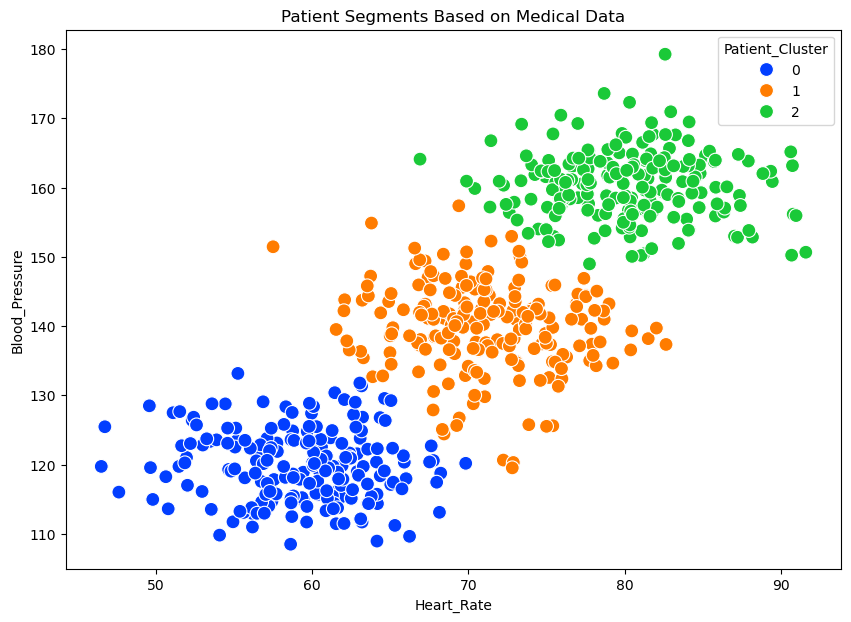

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # --- Step 1: Generate a Realistic Healthcare Dataset ---
    np.random.seed(42)
    n_patients = 600
    
    # Generate 3 distinct patient groups based on symptoms
    centers = [[80, 160], [60, 120], [70, 140]] # Centers for [HeartRate, BloodPressure]
    symptoms, true_labels = np.zeros((n_patients, 2)), np.zeros(n_patients)
    symptoms[:200, :], true_labels[:200] = centers[0] + np.random.randn(200, 2) * 5, 0 # Cardio Group
    symptoms[200:400, :], true_labels[200:400] = centers[1] + np.random.randn(200, 2) * 5, 1 # Healthy Group
    symptoms[400:, :], true_labels[400:] = centers[2] + np.random.randn(200, 2) * 5, 2 # At-Risk Group

    df = pd.DataFrame(symptoms, columns=['Heart_Rate', 'Blood_Pressure'])

    # Assign specific treatment patterns to each true group
    treatments = []
    for label in true_labels:
        if label == 0: # Cardio Group
            treatments.append(['Aspirin', 'Beta_Blocker'] + list(np.random.choice(['Statin', 'Diet_Plan'], 1)))
        elif label == 1: # Healthy Group
            treatments.append(['Annual_Checkup', 'Vitamin_D'] + list(np.random.choice(['Exercise_Plan'], 1)))
        else: # At-Risk Group
            treatments.append(['Diet_Plan', 'Exercise_Plan'] + list(np.random.choice(['Aspirin', 'Metformin'], 1)))
    df['Treatments'] = treatments
    
    print("--- Step 1: Synthetic Patient Data Generated ---")
    print(df.head())
    print("\n")

    # --- Part 1: Clustering to Find Patient Groups ---
    # Preprocess the symptom data
    X_symptoms = df[['Heart_Rate', 'Blood_Pressure']]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_symptoms)

    # Apply K-Means
    k = 3
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    df['Patient_Cluster'] = kmeans.fit_predict(X_scaled)
    
    print(f"--- Part 1: K-Means Clustering Complete ---")
    print("Patients grouped into 3 clusters based on symptoms.\n")

    # Visualize the clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x='Heart_Rate', y='Blood_Pressure', hue='Patient_Cluster', palette='bright', s=100)
    plt.title('Patient Segments Based on Medical Data')
    plt.savefig('patient_clusters.png')
    print("Patient cluster plot saved as 'patient_clusters.png'\n")

    # --- Part 2: Association Rules to Find Treatment Patterns per Group ---
    print("--- Part 2: Discovering Personalized Treatment Rules ---\n")

    # Loop through each patient cluster and run a separate analysis
    for i in range(k):
        print(f"--- Analysis for Patient Cluster {i} ---")
        
        # Filter data for the current cluster
        cluster_df = df[df['Patient_Cluster'] == i]
        
        # Get the list of treatments for this cluster
        transactions = cluster_df['Treatments'].tolist()
        
        if len(transactions) < 2:
            print("Not enough data to find rules for this cluster.\n")
            continue
            
        # Format data for Apriori
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        rules_df = pd.DataFrame(te_ary, columns=te.columns_)
        
        # Apply Apriori and generate rules
        frequent_itemsets = apriori(rules_df, min_support=0.3, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
        
        if rules.empty:
            print("No strong association rules found for this cluster.\n")
        else:
            print("Common Treatment Patterns:")
            print(rules[['antecedents', 'consequents', 'support', 'confidence']])
            print("\n")

    print("\n--- Analysis Complete ---")

except Exception as e:
    print(f"An error occurred: {e}")